# 01 为什么需要卷积？

> 从全连接网络的困境到卷积的解决方案

---

## 📚 学习目标

在本章结束后，你将能够：

- [ ] 理解图像数据的特殊性（局部性、平移不变性）
- [ ] 计算全连接网络处理图像的参数量
- [ ] 理解卷积操作的直觉：滤波器/特征检测器
- [ ] 可视化边缘检测、模糊等滤波效果

## 🔍 前置知识

请确保已完成：

- ✅ **阶段3 神经网络基础**：理解前向传播、全连接层
- ✅ **NumPy 基础**：矩阵运算

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
import requests
from io import BytesIO

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
np.random.seed(42)

print("环境准备完成！")

环境准备完成！


---

## 💡 第一部分：全连接网络的困境

### 问题：用全连接网络处理图像会怎样？

在阶段3，我们学习了多层感知机（MLP），它由全连接层组成。

**回顾：全连接层**
- 每个输入都连接到每个输出
- 参数量 = 输入维度 × 输出维度 + 偏置

In [2]:
# ============================================================
# 计算全连接网络处理图像的参数量
# ============================================================

def calc_fc_params(input_size, hidden_size):
    """
    计算全连接层的参数量
    
    参数:
        input_size: 输入维度（展平后的像素数）
        hidden_size: 隐藏层神经元数量
    
    返回:
        参数量（权重 + 偏置）
    """
    # 权重矩阵: input_size × hidden_size
    # 偏置向量: hidden_size
    return input_size * hidden_size + hidden_size


# ============================================================
# 例子1: MNIST 手写数字 (28×28 灰度图)
# ============================================================
mnist_input = 28 * 28  # 784 像素
hidden_neurons = 1000

mnist_params = calc_fc_params(mnist_input, hidden_neurons)
print("=" * 50)
print("例子1: MNIST 手写数字 (28×28 灰度图)")
print("=" * 50)
print(f"输入维度: {mnist_input:,} 像素")
print(f"隐藏层神经元: {hidden_neurons:,} 个")
print(f"第一层参数量: {mnist_params:,} 个")
print(f"约等于: {mnist_params / 1e6:.2f} 百万参数")

例子1: MNIST 手写数字 (28×28 灰度图)
输入维度: 784 像素
隐藏层神经元: 1,000 个
第一层参数量: 785,000 个
约等于: 0.79 百万参数


In [3]:
# ============================================================
# 例子2: ImageNet 标准图像 (224×224 RGB)
# ============================================================
imagenet_input = 224 * 224 * 3  # 150,528 像素
hidden_neurons = 1000

imagenet_params = calc_fc_params(imagenet_input, hidden_neurons)
print("\n" + "=" * 50)
print("例子2: ImageNet 图像 (224×224 RGB)")
print("=" * 50)
print(f"输入维度: {imagenet_input:,} 像素")
print(f"隐藏层神经元: {hidden_neurons:,} 个")
print(f"第一层参数量: {imagenet_params:,} 个")
print(f"约等于: {imagenet_params / 1e6:.2f} 百万参数")
print("\n⚠️ 这只是第一层！整个网络的参数会更多！")


例子2: ImageNet 图像 (224×224 RGB)
输入维度: 150,528 像素
隐藏层神经元: 1,000 个
第一层参数量: 150,529,000 个
约等于: 150.53 百万参数

⚠️ 这只是第一层！整个网络的参数会更多！


In [4]:
# ============================================================
# 例子3: 高清图像 (1920×1080 RGB)
# ============================================================
hd_input = 1920 * 1080 * 3  # 6,220,800 像素
hidden_neurons = 1000

hd_params = calc_fc_params(hd_input, hidden_neurons)
print("\n" + "=" * 50)
print("例子3: 高清图像 (1920×1080 RGB)")
print("=" * 50)
print(f"输入维度: {hd_input:,} 像素")
print(f"隐藏层神经元: {hidden_neurons:,} 个")
print(f"第一层参数量: {hd_params:,} 个")
print(f"约等于: {hd_params / 1e9:.2f} 十亿参数！")
print("\n💀 这完全不可行！")


例子3: 高清图像 (1920×1080 RGB)
输入维度: 6,220,800 像素
隐藏层神经元: 1,000 个
第一层参数量: 6,220,801,000 个
约等于: 6.22 十亿参数！

💀 这完全不可行！


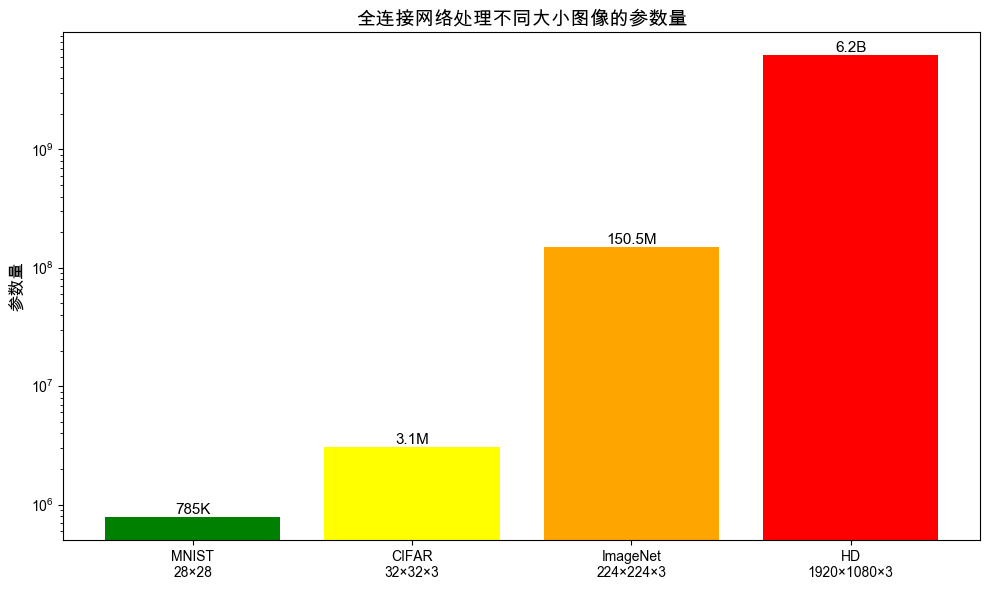


📊 结论：全连接网络处理图像的参数量随图像大小呈指数级增长！


In [5]:
# ============================================================
# 可视化：参数量爆炸
# ============================================================
image_sizes = [
    ("MNIST\n28×28", 28*28),
    ("CIFAR\n32×32×3", 32*32*3),
    ("ImageNet\n224×224×3", 224*224*3),
    ("HD\n1920×1080×3", 1920*1080*3)
]

labels = [x[0] for x in image_sizes]
params = [calc_fc_params(x[1], 1000) for x in image_sizes]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, params, color=['green', 'yellow', 'orange', 'red'])
plt.ylabel('参数量', fontsize=12)
plt.title('全连接网络处理不同大小图像的参数量', fontsize=14)
plt.yscale('log')  # 对数坐标

# 添加数值标签
for bar, param in zip(bars, params):
    if param >= 1e9:
        label = f'{param/1e9:.1f}B'
    elif param >= 1e6:
        label = f'{param/1e6:.1f}M'
    else:
        label = f'{param/1e3:.0f}K'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             label, ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("\n📊 结论：全连接网络处理图像的参数量随图像大小呈指数级增长！")

### 🤔 问题不只是参数多

全连接网络处理图像还有两个根本问题：

1. **忽略空间结构**：图像被展平成一维向量，像素之间的空间关系丢失
2. **无法共享特征**：同一个特征（如边缘）在不同位置需要重新学习

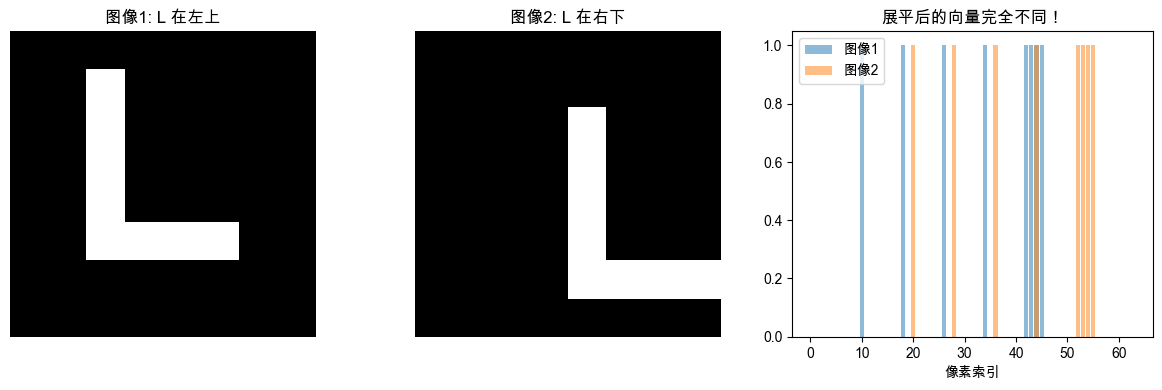


💡 虽然两张图都包含 'L' 形状，但展平后的向量完全不同
   全连接网络无法识别这是同一个特征！


In [6]:
# ============================================================
# 演示：全连接网络的问题
# ============================================================

# 创建一个简单的 8x8 图像，包含一个 "L" 形状
image1 = np.zeros((8, 8))
image1[1:6, 2] = 1  # 竖线
image1[5, 2:6] = 1  # 横线

# 同样的 L，但在不同位置
image2 = np.zeros((8, 8))
image2[2:7, 4] = 1
image2[6, 4:8] = 1

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image1, cmap='gray')
axes[0].set_title('图像1: L 在左上', fontsize=12)
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].set_title('图像2: L 在右下', fontsize=12)
axes[1].axis('off')

# 展平后的向量
flat1 = image1.flatten()
flat2 = image2.flatten()

axes[2].bar(range(64), flat1, alpha=0.5, label='图像1')
axes[2].bar(range(64), flat2, alpha=0.5, label='图像2')
axes[2].set_title('展平后的向量完全不同！', fontsize=12)
axes[2].legend()
axes[2].set_xlabel('像素索引')

plt.tight_layout()
plt.show()

print("\n💡 虽然两张图都包含 'L' 形状，但展平后的向量完全不同")
print("   全连接网络无法识别这是同一个特征！")

---

## 💡 第二部分：图像的特殊性质

图像有两个重要的统计特性，我们可以利用它们来设计更好的网络：

### 1. 局部性 (Locality)

**含义**：图像中的重要特征通常是局部的

- 边缘、角点只涉及相邻的几个像素
- 纹理模式在小区域内就能识别
- 不需要每个像素都连接到每个神经元

### 2. 平移不变性 (Translation Invariance)

**含义**：同一个特征可能出现在图像的任何位置

- "猫的眼睛" 可能在图像的左上角、中间或右下角
- 无论在哪里，检测方法应该是一样的
- 不需要为每个位置单独学习

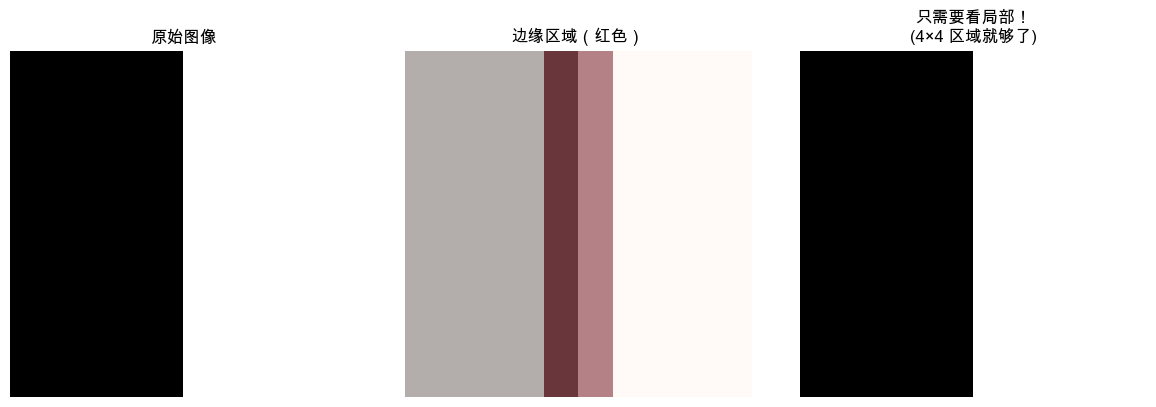


💡 局部性：检测边缘只需要看相邻的几个像素，不需要看整张图！


In [7]:
# ============================================================
# 演示：局部性 - 边缘是局部特征
# ============================================================

# 创建一个带有垂直边缘的图像
image = np.zeros((10, 10))
image[:, 5:] = 1  # 右半边是白色

# 标记边缘位置
edge_region = np.zeros((10, 10))
edge_region[:, 4:6] = 1

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('原始图像', fontsize=12)
axes[0].axis('off')

axes[1].imshow(edge_region, cmap='Reds', alpha=0.7)
axes[1].imshow(image, cmap='gray', alpha=0.3)
axes[1].set_title('边缘区域（红色）', fontsize=12)
axes[1].axis('off')

# 显示边缘检测只需要看局部
local_patch = image[3:7, 3:7]
axes[2].imshow(local_patch, cmap='gray')
axes[2].set_title('只需要看局部！\n(4×4 区域就够了)', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 局部性：检测边缘只需要看相邻的几个像素，不需要看整张图！")

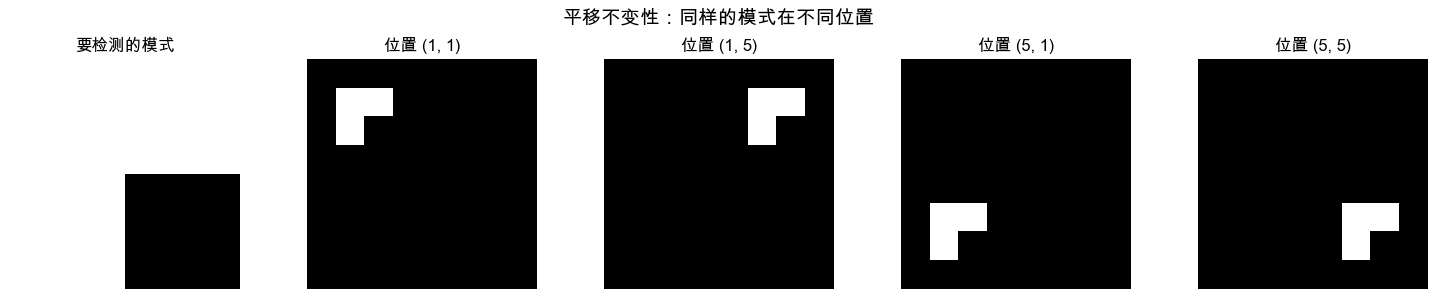


💡 平移不变性：同一个检测器应该能在任何位置识别这个模式！


In [8]:
# ============================================================
# 演示：平移不变性 - 同样的模式在不同位置
# ============================================================

# 创建一个小的模式（比如一个小方块）
pattern = np.array([
    [1, 1],
    [1, 0]
])

# 在不同位置放置这个模式
images = []
positions = [(1, 1), (1, 5), (5, 1), (5, 5)]

for pos in positions:
    img = np.zeros((8, 8))
    img[pos[0]:pos[0]+2, pos[1]:pos[1]+2] = pattern
    images.append(img)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# 显示模式
axes[0].imshow(pattern, cmap='gray')
axes[0].set_title('要检测的模式', fontsize=12)
axes[0].axis('off')

# 显示在不同位置的图像
for i, (img, pos) in enumerate(zip(images, positions)):
    axes[i+1].imshow(img, cmap='gray')
    axes[i+1].set_title(f'位置 {pos}', fontsize=12)
    axes[i+1].axis('off')

plt.suptitle('平移不变性：同样的模式在不同位置', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 平移不变性：同一个检测器应该能在任何位置识别这个模式！")

---

## 💡 第三部分：卷积的解决方案

### 卷积的核心思想

1. **局部连接**：每个输出只看输入的一小块区域（感受野）
2. **参数共享**：同一个滤波器在整张图上滑动使用

### 直觉：滤波器就是特征检测器

```
输入图像        滤波器（3×3）      输出特征图
┌─────────┐    ┌───────┐         ┌───────┐
│ · · · · │    │ w w w │         │ · · · │
│ · ■ ■ · │ ∗  │ w w w │   =     │ · ▲ · │  ← 检测到特征
│ · ■ ■ · │    │ w w w │         │ · · · │
│ · · · · │    └───────┘         └───────┘
└─────────┘
```

滤波器像一个"模板"，在图像上滑动，找到匹配的地方。

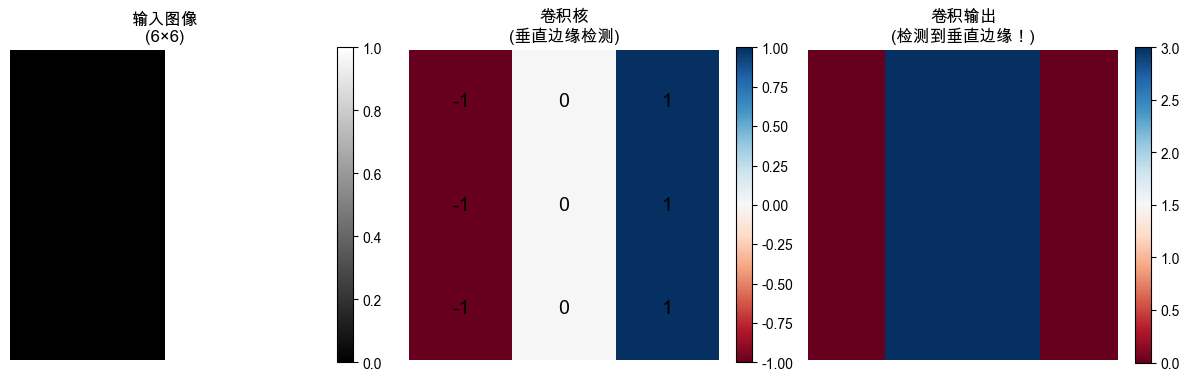


💡 卷积核检测到了图像中间的垂直边缘（高响应区域）！


In [9]:
# ============================================================
# 卷积操作的直观演示
# ============================================================

def simple_convolve(image, kernel):
    """
    简单的 2D 卷积实现（用于演示）
    
    参数:
        image: 输入图像, shape (H, W)
        kernel: 卷积核, shape (k, k)
    
    返回:
        output: 卷积结果
    """
    H, W = image.shape
    k = kernel.shape[0]
    
    # 输出尺寸
    out_h = H - k + 1
    out_w = W - k + 1
    
    output = np.zeros((out_h, out_w))
    
    # 滑动窗口
    for i in range(out_h):
        for j in range(out_w):
            # 提取局部区域
            patch = image[i:i+k, j:j+k]
            # 逐元素相乘并求和
            output[i, j] = np.sum(patch * kernel)
    
    return output


# 创建一个 6×6 的测试图像
test_image = np.array([
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1]
], dtype=float)

# 垂直边缘检测核
vertical_edge_kernel = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=float)

# 执行卷积
output = simple_convolve(test_image, vertical_edge_kernel)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

im0 = axes[0].imshow(test_image, cmap='gray')
axes[0].set_title('输入图像\n(6×6)', fontsize=12)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(vertical_edge_kernel, cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('卷积核\n(垂直边缘检测)', fontsize=12)
axes[1].axis('off')
# 显示数值
for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{vertical_edge_kernel[i,j]:.0f}', 
                    ha='center', va='center', fontsize=14)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(output, cmap='RdBu')
axes[2].set_title('卷积输出\n(检测到垂直边缘！)', fontsize=12)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

print("\n💡 卷积核检测到了图像中间的垂直边缘（高响应区域）！")

---

## 📊 第四部分：常见滤波器效果展示

不同的卷积核可以检测不同的特征：

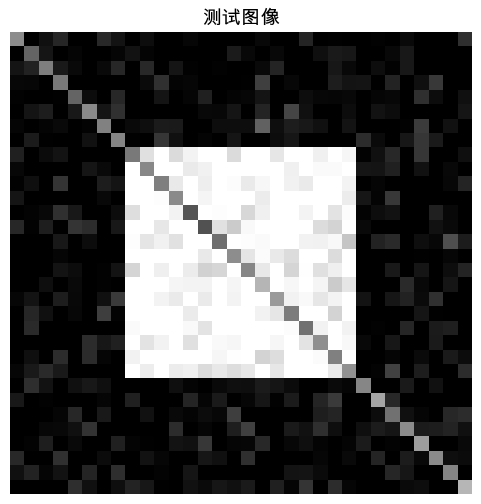

In [10]:
# ============================================================
# 创建测试图像
# ============================================================

# 创建一个更复杂的测试图像
def create_test_image():
    """创建一个包含各种特征的测试图像"""
    img = np.zeros((32, 32))
    
    # 添加一个矩形
    img[8:24, 8:24] = 1
    
    # 添加一条对角线
    for i in range(32):
        if 0 <= i < 32:
            img[i, i] = 0.5
    
    # 添加一些噪声
    noise = np.random.randn(32, 32) * 0.1
    img = img + noise
    
    return np.clip(img, 0, 1)

test_img = create_test_image()

plt.figure(figsize=(6, 6))
plt.imshow(test_img, cmap='gray')
plt.title('测试图像', fontsize=14)
plt.axis('off')
plt.show()

In [12]:
# ============================================================
# 定义各种常见的卷积核
# ============================================================

# 1. 恒等核（不改变图像）
identity_kernel = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
], dtype=float)

# 2. 边缘检测核（Sobel 水平）
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=float)

# 3. 边缘检测核（Sobel 垂直）
sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=float)

# 4. 锐化核
sharpen_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=float)

# 5. 模糊核（均值滤波）
blur_kernel = np.ones((3, 3), dtype=float) / 9

# 6. 高斯模糊核
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=float) / 16

# 7. 拉普拉斯核（边缘检测）
laplacian_kernel = np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
], dtype=float)

# 8. 浮雕效果
emboss_kernel = np.array([
    [-2, -1, 0],
    [-1,  1, 1],
    [ 0,  1, 2]
], dtype=float)

kernels = [
    ('恒等', identity_kernel),
    ('Sobel 水平边缘', sobel_x),
    ('Sobel 垂直边缘', sobel_y),
    ('锐化', sharpen_kernel),
    ('均值模糊', blur_kernel),
    ('高斯模糊', gaussian_kernel),
    ('拉普拉斯边缘', laplacian_kernel),
    ('浮雕', emboss_kernel)
]

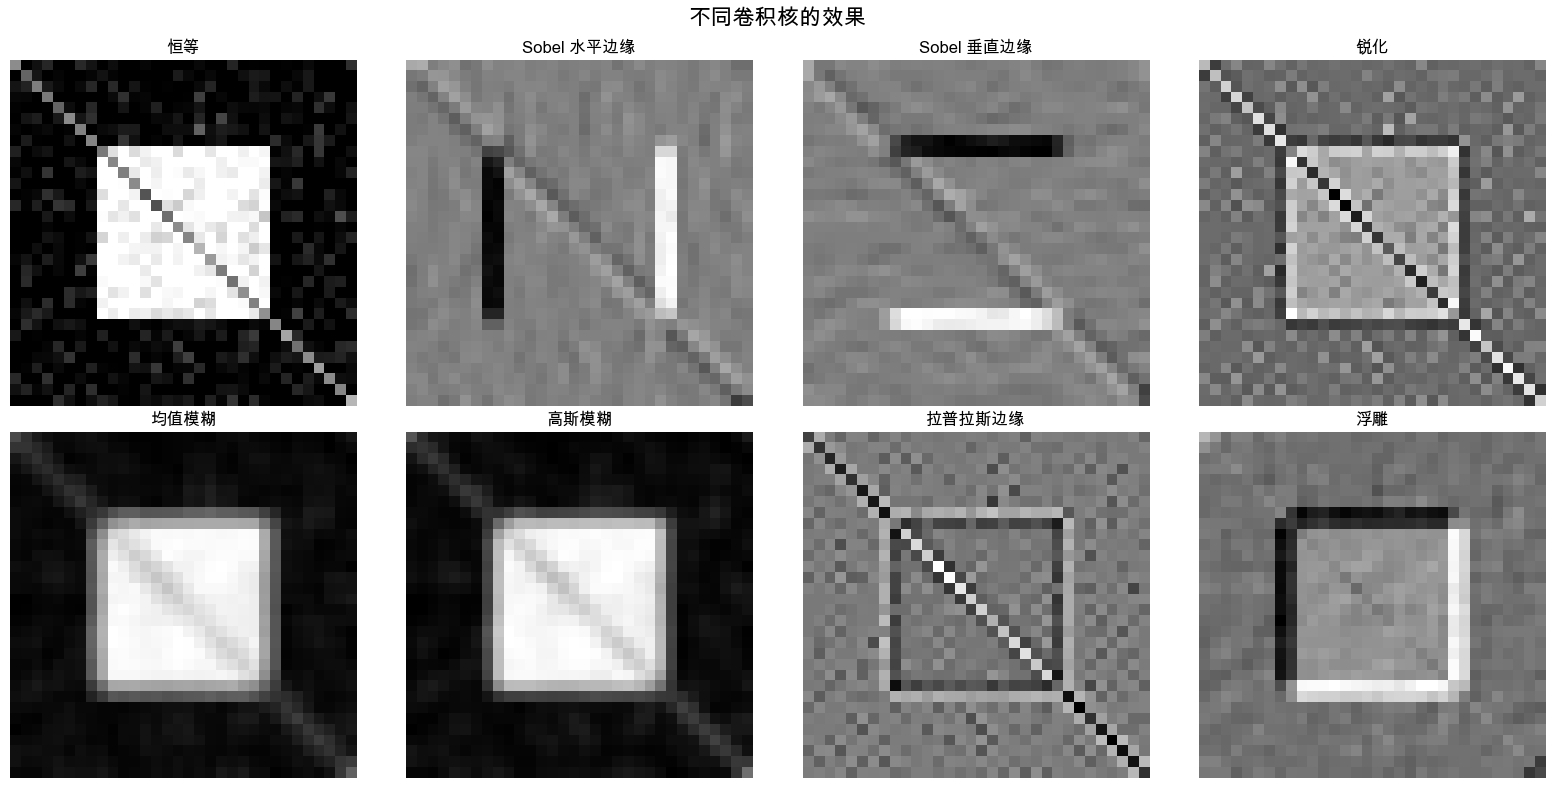

In [13]:
# ============================================================
# 应用所有卷积核并可视化
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, kernel) in enumerate(kernels):
    # 使用 scipy 的卷积函数（更稳定）
    result = ndimage.convolve(test_img, kernel)
    
    axes[idx].imshow(result, cmap='gray')
    axes[idx].set_title(name, fontsize=12)
    axes[idx].axis('off')

plt.suptitle('不同卷积核的效果', fontsize=16)
plt.tight_layout()
plt.show()

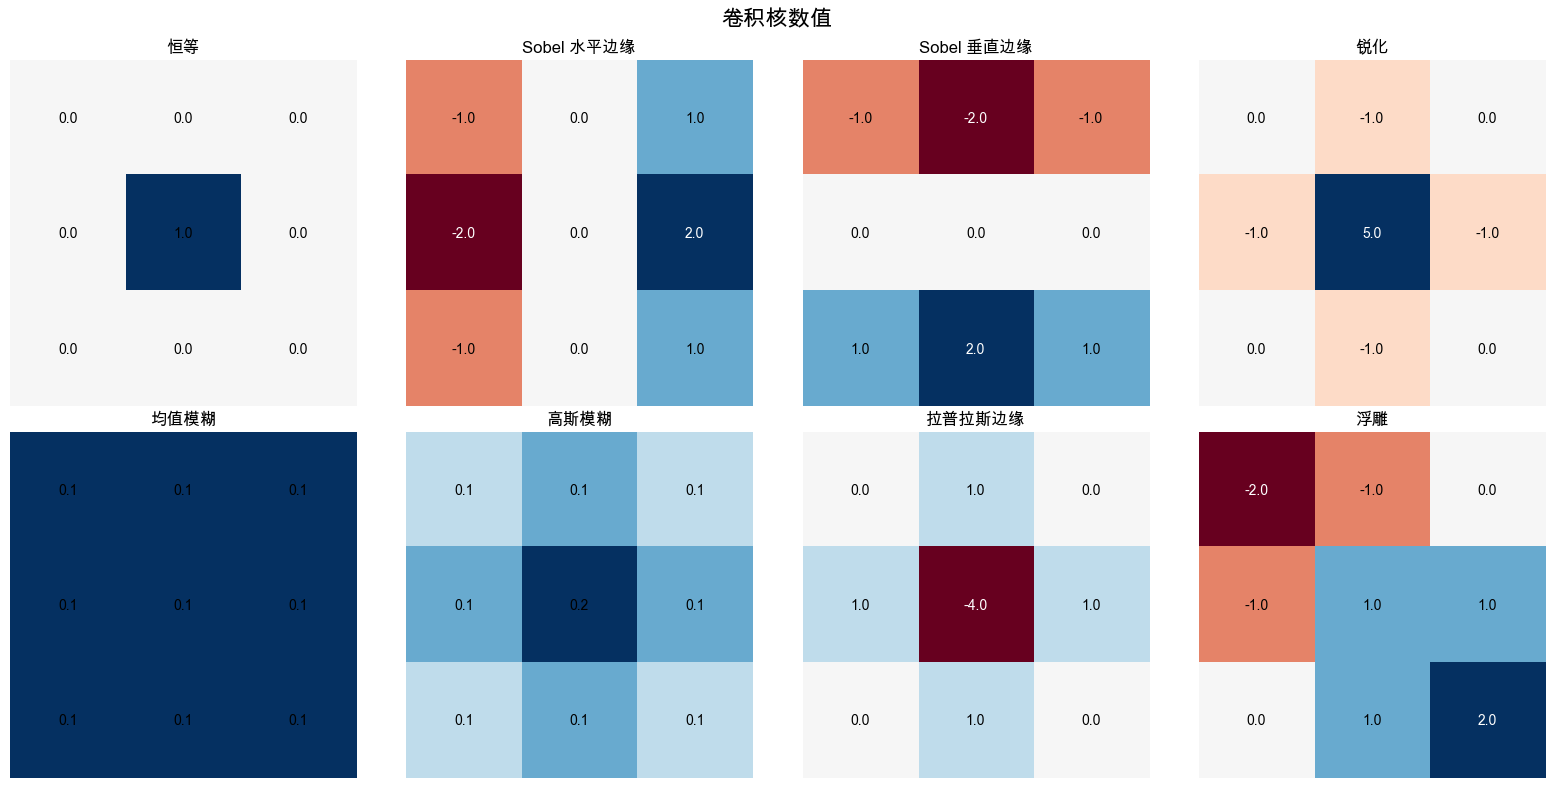


💡 观察卷积核的模式：
   - 边缘检测核的两侧符号相反（检测变化）
   - 模糊核的值都是正的且相等（求平均）
   - 锐化核中心值大，周围为负（增强对比）


In [14]:
# ============================================================
# 显示卷积核的值
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, kernel) in enumerate(kernels):
    im = axes[idx].imshow(kernel, cmap='RdBu', 
                          vmin=-max(abs(kernel.min()), abs(kernel.max())),
                          vmax=max(abs(kernel.min()), abs(kernel.max())))
    axes[idx].set_title(name, fontsize=12)
    
    # 显示数值
    for i in range(3):
        for j in range(3):
            val = kernel[i, j]
            color = 'white' if abs(val) > 1 else 'black'
            axes[idx].text(j, i, f'{val:.1f}', ha='center', va='center', 
                          fontsize=10, color=color)
    axes[idx].axis('off')

plt.suptitle('卷积核数值', fontsize=16)
plt.tight_layout()
plt.show()

print("\n💡 观察卷积核的模式：")
print("   - 边缘检测核的两侧符号相反（检测变化）")
print("   - 模糊核的值都是正的且相等（求平均）")
print("   - 锐化核中心值大，周围为负（增强对比）")

---

## 💰 第五部分：参数效率对比

让我们对比全连接层和卷积层的参数量：

In [15]:
# ============================================================
# 参数量对比：全连接 vs 卷积
# ============================================================

def calc_conv_params(kernel_size, in_channels, out_channels):
    """
    计算卷积层的参数量
    
    参数:
        kernel_size: 卷积核大小 (k×k)
        in_channels: 输入通道数
        out_channels: 输出通道数（滤波器数量）
    
    返回:
        参数量（权重 + 偏置）
    
    公式:
        权重: k × k × in_channels × out_channels
        偏置: out_channels
    """
    weight_params = kernel_size * kernel_size * in_channels * out_channels
    bias_params = out_channels
    return weight_params + bias_params


# ImageNet 图像 (224×224×3)
input_h, input_w, input_c = 224, 224, 3
input_size = input_h * input_w * input_c

# 方案1：全连接层（1000 个输出神经元）
fc_params = calc_fc_params(input_size, 1000)

# 方案2：卷积层（3×3 核，64 个滤波器）
conv_params = calc_conv_params(kernel_size=3, in_channels=3, out_channels=64)

print("=" * 60)
print("处理 224×224×3 图像的参数量对比")
print("=" * 60)
print(f"\n全连接层 (1000 神经元):")
print(f"  参数量: {fc_params:,} 个")
print(f"  约: {fc_params / 1e6:.2f} M (百万)")

print(f"\n卷积层 (3×3 核, 64 个滤波器):")
print(f"  参数量: {conv_params:,} 个")
print(f"  约: {conv_params / 1e3:.2f} K (千)")

print(f"\n📊 卷积层参数量是全连接层的 {fc_params / conv_params:.0f} 分之一！")

处理 224×224×3 图像的参数量对比

全连接层 (1000 神经元):
  参数量: 150,529,000 个
  约: 150.53 M (百万)

卷积层 (3×3 核, 64 个滤波器):
  参数量: 1,792 个
  约: 1.79 K (千)

📊 卷积层参数量是全连接层的 84001 分之一！


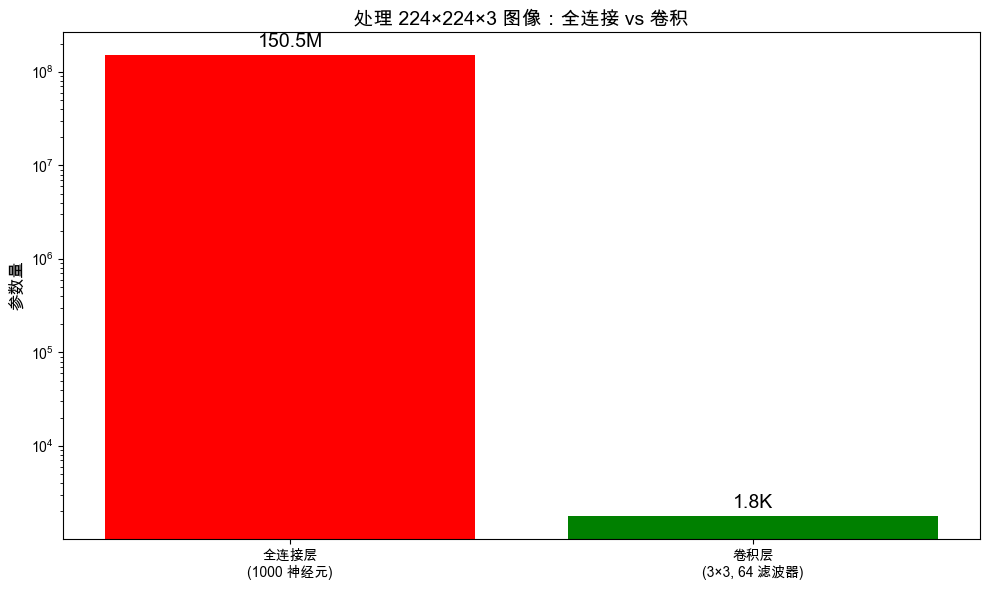


✅ 卷积的优势：
   1. 参数量大幅减少（易于训练）
   2. 保留空间结构（不丢失位置信息）
   3. 参数共享（同一特征到处适用）


In [16]:
# ============================================================
# 可视化参数量差异
# ============================================================

fig, ax = plt.subplots(figsize=(10, 6))

methods = ['全连接层\n(1000 神经元)', '卷积层\n(3×3, 64 滤波器)']
params = [fc_params, conv_params]
colors = ['red', 'green']

bars = ax.bar(methods, params, color=colors)
ax.set_ylabel('参数量', fontsize=12)
ax.set_title('处理 224×224×3 图像：全连接 vs 卷积', fontsize=14)
ax.set_yscale('log')

# 添加数值标签
for bar, param in zip(bars, params):
    if param >= 1e6:
        label = f'{param/1e6:.1f}M'
    else:
        label = f'{param/1e3:.1f}K'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
            label, ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ 卷积的优势：")
print("   1. 参数量大幅减少（易于训练）")
print("   2. 保留空间结构（不丢失位置信息）")
print("   3. 参数共享（同一特征到处适用）")

---

## 📝 本章小结

### 核心要点

1. **全连接网络的问题**
   - 参数量随图像尺寸爆炸式增长
   - 忽略图像的空间结构
   - 无法共享特征

2. **图像的特殊性质**
   - **局部性**：重要特征是局部的
   - **平移不变性**：特征可能在任何位置

3. **卷积的解决方案**
   - **局部连接**：只看局部区域
   - **参数共享**：同一滤波器扫描全图
   - 参数量大幅减少

4. **滤波器 = 特征检测器**
   - 不同的核检测不同特征
   - 边缘、纹理、形状等

### 关键公式预告

下一章我们将学习：

- 卷积的数学定义
- 输出尺寸公式
- Padding 和 Stride

---

## 🎯 练习

### 练习 1：参数计算

计算以下情况的全连接层参数量：
1. 输入 64×64 灰度图，512 个隐藏神经元
2. 输入 128×128×3 RGB图，256 个隐藏神经元

### 练习 2：设计滤波器

设计一个 3×3 卷积核来检测：
1. 水平边缘
2. 对角线边缘

### 练习 3：思考题

为什么边缘检测核的元素和通常为 0？

In [ ]:
# ============================================================
# 练习答案区域（先自己思考！）
# ============================================================

# 练习1 答案
print("练习1 答案：")
print(f"1. 64×64 灰度图: {calc_fc_params(64*64, 512):,} 参数")
print(f"2. 128×128×3 RGB: {calc_fc_params(128*128*3, 256):,} 参数")

# 练习2 答案
print("\n练习2 答案：")
horizontal_edge = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])
print("水平边缘核:")
print(horizontal_edge)

diagonal_edge = np.array([
    [ 0,  1,  1],
    [-1,  0,  1],
    [-1, -1,  0]
])
print("\n对角线边缘核:")
print(diagonal_edge)

# 练习3 答案
print("\n练习3 答案：")
print("边缘检测核元素和为 0，因为：")
print("- 在均匀区域（无边缘），所有像素值相近")
print("- 正负抵消，输出接近 0")
print("- 只在有变化的地方（边缘）产生非零输出")

---

## 🚀 下一步

继续学习 **02_convolution_math.ipynb** - 卷积的数学原理

你将学到：
- 卷积的数学公式
- 输出尺寸计算
- Padding 和 Stride